# Direct Fidelity Estimation

Using a method known as direct fidelity estimation (DFE), see [DFE1] and [DFE2], it is possible to estimate the fidelity between 
* a target pure state $\rho_\psi = |\psi\rangle\langle \psi|$ to its experimental realization $\sigma$,
* a target unitary $U$ to its experimental realization $U_e$.
 
This can be done with a small number (relative to state and process tomography) of simple experimental settings that is independent of the system size. Such methods are useful for the experimental study of larger quantum information processing units.

In this notebook we explore some state and process DFE using the forest.benchmarking module `direct_fidelity_estimation.py`.

## Simplistic example

Suppose we have tried to prepare the state $|0\rangle$ but in fact prepared the state

$$\sigma = \frac 1 2 (I + x X + y Y + z Z).$$


The usual way to quantify how close $\sigma$ and $|0\rangle$ are is to do quantum state tomography 
and estimate $\sigma$ and then calculate the fidelity be $\sigma$ and $|0\rangle$.


DFE provides a way to directly estimate the fidelity without first estimating the state $\sigma$. Although we can write the fidelity as $F(\rho_0, \sigma) = \langle 0 |\sigma|0 \rangle$ we use the expression

$$
F(\rho_0, \sigma) = {\rm Tr}[\rho_0  \sigma].
$$
Next we parameterize the pure state as

$$\rho_0= |0\rangle \langle 0| =  \frac 1 2 \big (I + (0) X + (0) Y + (+1) Z \big)=  \frac 1 2 (I +  Z ).$$

Finally we arrive at

$$
F(\rho_0, \sigma)= {\rm Tr}[\rho_0 \sigma] = \frac 1 4 {\rm Tr}[(1+z)I]= \frac{(1+z)}{2},
$$
this result shows that we only need to estimate one observable $\langle Z \rangle$ in order to estimate the fidelity between $\rho_0$ and $\sigma$ in this particular example.


## Addtional Details

**State DFE:** State fidelity between the experimental state $\sigma$ and the ideal (pure) state $\rho_\psi = |\psi\rangle\langle \psi|$ 
matrices is 

$$
F(\rho_\psi, \sigma) = {\rm Tr}[\rho_\psi  \sigma] = \langle \psi |\sigma|\psi \rangle.
$$

The direct fidelity estimate for a state is given by the average expected value of the Pauli operators in the
stabilizer group of the ideal pure state (see Eqn. 1 of [DFE1]).

**Process DFE:** The average gate fidelity between the experimental process $\mathcal E$ and the ideal (unitary) process $\mathcal U$ is defined as
$$
F(\mathcal U,\mathcal E) = \frac{ {\rm Tr} [\mathcal E \mathcal U^\dagger] + d} {d^2+d} 
$$
where the processes are represented by linear superoperators acting of vectorized
density matrices, and d is the dimension of the Hilbert space $\mathcal E$ and $\mathcal U$ act on. If you are unfamiliar with these terms look at [superoperator tools notebook](superoperator_tools.ipynb) and [superoperator_representations.md](../.././forest-benchmarking/docs/superoperator_representations.md)

The average gate fidelity can be re-written a 
$$
F(\mathcal U,\mathcal E)= \frac{d^2 {\rm Tr} J(\mathcal E)⋅J(\mathcal U) + d}{d^2+d}
$$
where $J()$ is the Choi-Jamiolkoski representation of the superoperator in the argument. Since the Choi-Jamiolkowski representation
is given by a density operator, the connection to the calculation of state fidelity becomes apparent:
$F(J(ℰ),J(𝒰)) = {\rm Tr} J(\mathcal E)⋅J(\mathcal U)$ is the state fidelity between Choi-Jamiolkoski states.

Noting that the Choi-Jamiolkoski state is prepared by acting on half of a maximally entangled state with the
process in question, the direct fidelity estimate of the Choi-Jamiolkoski state is given by the average expected
value of a Pauli operator resulting from applying the ideal unitary $\mathcal U$ to a Pauli operator $P_i$, for the state
resulting from applying the ideal unitary to a stabilizer state that has $P_i$ in its stabilizer group (one must be
careful to prepare states that have both +1 and -1 eigenstates of the operator in question, to emulate the random
state preparation corresponding to measuring half of a maximally entangled state).

[DFE1]  Practical Characterization of Quantum Devices without Tomography  
        Silva et al.,  
        PRL 107, 210404 (2011)  
        https://doi.org/10.1103/PhysRevLett.107.210404  
        https://arxiv.org/abs/1104.3835  

[DFE2]  Direct Fidelity Estimation from Few Pauli Measurements  
        Flammia et al.,  
        PRL 106, 230501 (2011)  
        https://doi.org/10.1103/PhysRevLett.106.230501  
        https://arxiv.org/abs/1104.4695  

In [1]:
from pyquil.paulis import ID
from pyquil.gates import I, X, MEASURE, H, CNOT, RY
from pyquil import Program, get_qc
from pyquil.api import get_benchmarker
from forest.benchmarking.direct_fidelity_estimation import ( generate_exhaustive_state_dfe_experiment, 
                                                             generate_exhaustive_process_dfe_experiment,
                                                             generate_monte_carlo_state_dfe_experiment, 
                                                             generate_monte_carlo_process_dfe_experiment,
                                                             acquire_dfe_data,
                                                             estimate_dfe )
from pyquil.operator_estimation import measure_observables

import numpy as np
from matplotlib import pyplot

In [2]:
# noiseless QVM
qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=False)

# noisy QVM
noisy_qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=True)

bm = get_benchmarker()

## Direct fidelity estimation in `forest.benchmarking`

The basic workflow is:

1. Prepare a *state* or a *process* by specifying a pyQuil program.
2. Construct a list of observables that are needed to estimate the state; we collect this into an object called an `ObservablesExperiment`.
3. Acquire the data by running the program on a QVM or QPU.
4. Apply an estimator to the data to obtain an estimate of the fidelity between the ideal and measured state or process.
5. Visualize if you wish.

## Two quick examples

### Step 1. Prepare a state or unitarty with a `Program`

This is the object we will do DFE on.

The process we choose is 
$$
U = {\rm CNOT}(H\otimes I)=\frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 0 & 1 & 0\\
0 & 1 & 0 & 1\\
0 & 1 & 0 & -1\\
1 & 0 & -1 & 0
\end{pmatrix}
$$
and the state is
$$
|\Psi\rangle = {\rm CNOT}(H\otimes I)|00\rangle = \frac{1}{\sqrt{2}} \begin{pmatrix} 1\\0\\0\\ 1\end{pmatrix}.
$$

In [3]:
p = Program()
prep_prog = p.inst(H(0), CNOT(0,1))
print(prep_prog)

H 0
CNOT 0 1



In [5]:
from pyquil.gate_matrices import I as Imatrix, H as Hmatrix, CNOT as CNOTmatrix

U_ideal = CNOTmatrix @ np.kron(Hmatrix, Imatrix)
print(U_ideal)

rho_ideal = U_ideal @ np.array([[1], [0], [0], [0]]) @ np.array([[1], [0], [0], [0]]).T @ U_ideal.conj().T
print(rho_ideal)

[[ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.70710678  0.          0.70710678]
 [ 0.          0.70710678  0.         -0.70710678]
 [ 0.70710678  0.         -0.70710678  0.        ]]
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


### Step 2. Construct a `ObservablesExperiment` for DFE

We use the helper functions  
* `generate_exhaustive_state_dfe_experiment` 
* `generate_exhaustive_process_dfe_experiment`

to construct a tomographically incomplete set of measurements.

We can print this out to see the 15 observables or operator measurements we will perform. Note that we could have included an additional observable `I0I1`, but since this trivially gives an expectation of 1 we instead omit this observable in experiment generation and include its contribution by hand in the estimation methods. Be mindful of this if generating your own settings.

In [6]:
qubits = [0,1]

# state dfe
state_exp = generate_exhaustive_state_dfe_experiment(prep_prog, qubits, bm)

# process dfe
process_exp = generate_exhaustive_process_dfe_experiment(prep_prog, qubits, bm)

In [7]:
# Lets take a look into one of these experiment objects

print('The type of the object is:', type(state_exp),'\n')
print('The program is:')
print(state_exp.program)
print('There are three experiments:')
print(state_exp.settings_string())

The type of the object is: <class 'forest.benchmarking.observable_estimation.ObservablesExperiment'> 

The program is:
H 0
CNOT 0 1

There are three experiments:
0: Z0_1→(1+0j)*Z0Z1
1: Z0_0→(1+0j)*X0X1
2: Z0_0 * Z0_1→(-1+0j)*Y0Y1


### Step 3. Acquire the data

PyQuil will run the tomography programs. We will use the QVM but at this point you can use a QPU.

Note that `acquire_dfe_data` returns a `list` of `ExperimentResult`s which is a dataclass defined in the module `observable_estimation.py`.

The details of the dataclass and error mitigation strategies are in detail in the [observable estimation ipython notebook](observable_estimation.ipynb).

In [8]:
# get some NOISELESS data
results = acquire_dfe_data(qvm, process_exp, num_shots=1000)

In [9]:
# look at it
print("Operator Expectations")
print([res.expectation for res in results])
print('\n')
print("Calibration Expectations")
print([res.calibration_expectation for res in results])

Operator Expectations
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Calibration Expectations
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [10]:
# get some NOISY data
n_results_proce = acquire_dfe_data(noisy_qvm, process_exp, num_shots=1000)

n_results_state = acquire_dfe_data(noisy_qvm, state_exp, num_shots=1000)

In [11]:
# look at it
print("Noisy Operator Expectations")
print([np.round(res.expectation, 4) for res in n_results_proce])
print('\n')
print("Noisy Calibration Expectations")
print([res.calibration_expectation for res in n_results_proce])

Noisy Operator Expectations
[0.9989, 1.0057, 0.9796, 0.9746, 0.9819, 1.0065, 0.9733, 0.9948, 1.0203, 0.9657, 0.9897, 0.9797, 0.9819, 0.9599, 0.9941, 0.9764, 0.9806, 1.0171, 0.9695, 0.974, 0.9883, 0.982, 0.9921, 0.9759, 0.9726, 0.9358, 0.9816, 0.9845, 0.9764, 0.9663, 1.0157, 1.0111, 0.9606, 0.972, 0.9812, 0.9875, 0.9989, 0.953, 0.9784, 0.9993, 0.9836, 0.9534, 0.9886, 0.941, 0.9517, 0.9682, 1.019, 0.9934]


Noisy Calibration Expectations
[0.875, 0.875, 0.786, 0.786, 0.7715, 0.7715, 0.898, 0.762, 0.762, 0.875, 0.875, 0.886, 0.886, 0.898, 0.762, 0.762, 0.875, 0.875, 0.886, 0.886, 0.772, 0.889, 0.889, 0.7665, 0.7665, 0.7865, 0.7865, 0.772, 0.889, 0.889, 0.7665, 0.7665, 0.7865, 0.7865, 0.772, 0.881, 0.881, 0.787, 0.787, 0.762, 0.762, 0.772, 0.881, 0.881, 0.787, 0.787, 0.762, 0.762]


### Step 4. Apply some estimators to the data "do DFE"

**Process DFE**

In [12]:
# estimate using NOISELESS data
fid_est, fid_std_err = estimate_dfe(results, 'process')

print('Fidelity point estimate is: ',fid_est)
print('The standard error of the fidelity point estimate is: ', fid_std_err)

Fidelity point estimate is:  1.0
The standard error of the fidelity point estimate is:  0.0


In [13]:
# estimate using NOISY data
nfid_est, nfid_std_err = estimate_dfe(n_results_proce, 'process')

print('Fidelity point estimate is', np.round(nfid_est, 4))
print('The std error of the fidelity point estimate is', np.round(nfid_std_err, 4))

Fidelity point estimate is 0.9865
The std error of the fidelity point estimate is 0.0019


**State DFE**

In [14]:
# estimate using NOISY data
nfid_est_state, nfid_std_err_state = estimate_dfe(n_results_state, 'state')

print('Fidelity point estimate is', np.round(nfid_est_state, 4))
print('The std error of the fidelity point estimate is', np.round(nfid_std_err_state, 4))

Fidelity point estimate is 0.9826
The std error of the fidelity point estimate is 0.0077


### Step 5. Visualize


**State DFE**

We will start with state DFE as it is the simplest case.

In [15]:
from forest.benchmarking.tomography import iterative_mle_state_estimate

In [17]:
# use state tomography to estimate the state from incomplete information
rho_est = iterative_mle_state_estimate(n_results_state, qubits=[0,1])

np.round(rho_est, 3)

array([[ 0.494+0.j,  0.   +0.j,  0.   +0.j,  0.488+0.j],
       [ 0.   +0.j,  0.006+0.j, -0.   +0.j,  0.   +0.j],
       [ 0.   +0.j, -0.   +0.j,  0.006+0.j,  0.   +0.j],
       [ 0.488+0.j,  0.   +0.j,  0.   +0.j,  0.494+0.j]])

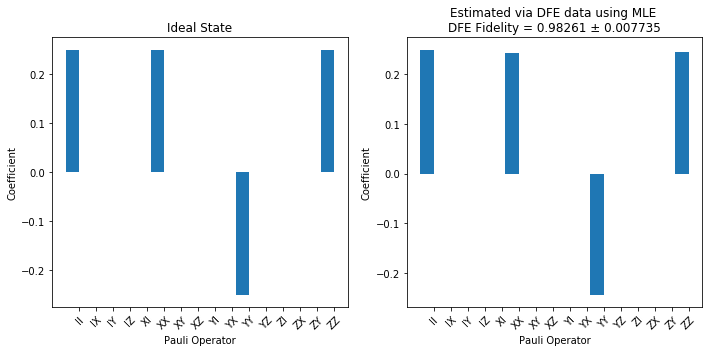

In [18]:
import matplotlib.pyplot as plt
from forest.benchmarking.utils import n_qubit_pauli_basis
from forest.benchmarking.operator_tools.superoperator_transformations import vec, computational2pauli_basis_matrix
from forest.benchmarking.plotting.state_process import plot_pauli_rep_of_state, plot_pauli_bar_rep_of_state

# convert to pauli representation
n_qubits = 2
pl_basis = n_qubit_pauli_basis(n_qubits)
c2p = computational2pauli_basis_matrix(2*n_qubits)


rho_true_pauli = np.real(c2p @ vec(rho_ideal))
rho_mle_pauli = np.real(c2p @ vec(rho_est)) 

fig1, (ax3, ax4) = plt.subplots(1, 2, figsize=(10,5))
title_res = f"Estimated via DFE data using MLE \n" f"DFE Fidelity = {np.round(nfid_est_state, 5)} ± {np.round(nfid_std_err_state, 6)}"
plot_pauli_bar_rep_of_state(rho_true_pauli.flatten(), ax=ax3, labels=pl_basis.labels, title='Ideal State')
plot_pauli_bar_rep_of_state(rho_mle_pauli.flatten(), ax=ax4, labels=pl_basis.labels, title=title_res)
fig1.tight_layout()

**Process DFE**

We will start with state DFE as it is the simplest case.

In [19]:
from forest.benchmarking.tomography import pgdb_process_estimate

choi_mle_est = pgdb_process_estimate(n_results_proce, qubits)

np.real_if_close(np.round(choi_mle_est, 3))

IndexError: 

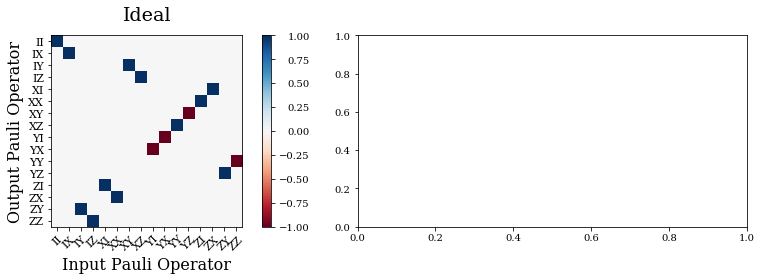

In [139]:
from forest.benchmarking.plotting.state_process import plot_pauli_transfer_matrix
from forest.benchmarking.operator_tools import choi2pauli_liouville, kraus2pauli_liouville


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
plot_pauli_transfer_matrix(np.real(kraus2pauli_liouville(U_ideal)), ax1, title='Ideal')
#plot_pauli_transfer_matrix(np.real(choi2pauli_liouville(choi_mle_est)), ax2, title='MLE Estimate')
plt.tight_layout()

## State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$

$$
\begin{align}
F\big(|0\rangle, R_y(\theta) |0\rangle \big) &= |\langle 0|R_y(\theta) |0\rangle |^2\\
&= \cos^2(\theta/2)\\
&= \frac{1}{2} \big (1 +\cos(\theta) \big) 
\end{align}
$$

In [140]:
#%%time
p = Program(I(0),I(1))
zz_state = generate_exhaustive_state_dfe_experiment(p, [0,1], bm)
zz_state_mc = generate_monte_carlo_state_dfe_experiment(p, [0,1], bm, n_terms=32)
print(zz_state)
print(zz_state_mc)

I 0; I 1
0: Z0_1→(1+0j)*Z1
1: Z0_0→(1+0j)*Z0
2: Z0_0 * Z0_1→(1+0j)*Z0Z1
I 0; I 1
0: Z0_0→(1+0j)*Z0
1: Z0_0→(1+0j)*Z0
2: Z0_0 * Z0_1→(1+0j)*Z0Z1
3: Z0_0→(1+0j)*Z0
4: Z0_0→(1+0j)*Z0
5: Z0_0→(1+0j)*Z0
6: Z0_1→(1+0j)*Z1
7: Z0_1→(1+0j)*Z1
8: Z0_0 * Z0_1→(1+0j)*Z0Z1
9: Z0_0 * Z0_1→(1+0j)*Z0Z1
... 12 not shown ...
... use e.settings_string() for all ...
22: Z0_1→(1+0j)*Z1
23: Z0_0 * Z0_1→(1+0j)*Z0Z1
24: Z0_0 * Z0_1→(1+0j)*Z0Z1
25: Z0_0→(1+0j)*Z0
26: Z0_0→(1+0j)*Z0
27: Z0_1→(1+0j)*Z1
28: Z0_0 * Z0_1→(1+0j)*Z0Z1
29: Z0_1→(1+0j)*Z1
30: Z0_1→(1+0j)*Z1
31: Z0_1→(1+0j)*Z1


### Exhaustive

In [141]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    zz_state.program = Program(RY(theta,0),RY(theta,1))
    zz_state_data = acquire_dfe_data(qvm,zz_state,num_shots=1000)
    fid_est, fid_std_err = estimate_dfe(zz_state_data, 'state')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

Text(0.5, 1.0, 'State fidelity between $\\left|0\\right\\rangle$ and $R_y(\\theta)\\left|0\\right\\rangle$')

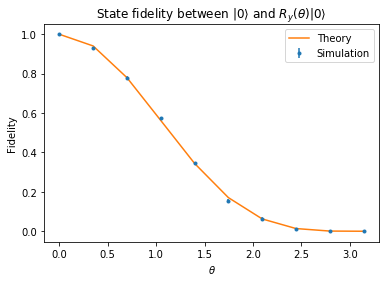

In [17]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(np.linspace(0, np.pi, points), (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))**2, label="Theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$")

### Monte-Carlo

In [18]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    zz_state_mc.program = Program(RY(theta,0),RY(theta,1))
    zz_state_mc_data = acquire_dfe_data(qvm, zz_state_mc, num_shots=1000)
    fid_est, fid_std_err = estimate_dfe(zz_state_mc_data, 'state')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

Text(0.5, 1.0, 'State fidelity between $\\left|0\\right\\rangle$ and $R_y(\\theta)\\left|0\\right\\rangle$')

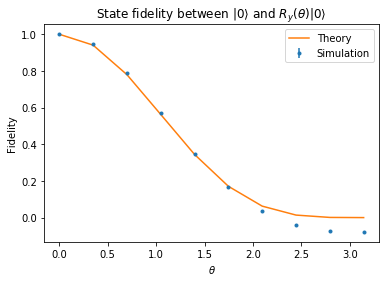

In [19]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(np.linspace(0, np.pi, points), (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))**2, label="Theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$")

## State fidelity between $\left|0\right\rangle\left|0\right\rangle$ and $R_y(\theta)\otimes R_y(2\theta)\left|0\right\rangle\left|0\right\rangle$

### Exhaustive

In [20]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    zz_state.program = Program(RY(theta,0),RY(2*theta,1))
    zz_state_data = acquire_dfe_data(qvm,zz_state,num_shots=1_000)
    fid_est, fid_std_err = estimate_dfe(zz_state_data, 'state')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

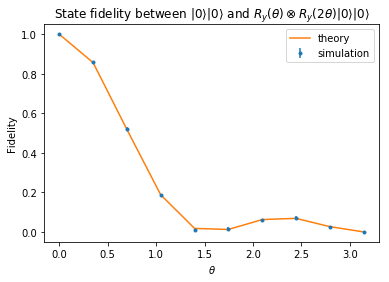

In [21]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="simulation")
pyplot.plot(np.linspace(0, np.pi, points), 
            (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))*(1/2+1/2*np.cos(2*np.linspace(0, np.pi, points))),
            label="theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle\left|0\right\rangle$ and $R_y(\theta)\otimes R_y(2\theta)\left|0\right\rangle\left|0\right\rangle$");

### Monte Carlo

In [22]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    zz_state_mc.program = Program(RY(theta,0),RY(2*theta,1))
    zz_state_mc_data = acquire_dfe_data(qvm,zz_state_mc,num_shots=1_000)
    fid_est, fid_std_err = estimate_dfe(zz_state_mc_data, 'state')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

Text(0.5, 1.0, 'State fidelity between $\\left|0\\right\\rangle\\left|0\\right\\rangle$ and $R_y(\\theta)\\otimes R_y(2\\theta)\\left|0\\right\\rangle\\left|0\\right\\rangle$')

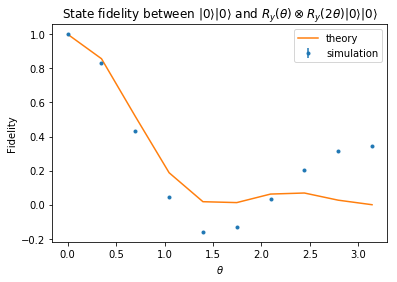

In [23]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="simulation")
pyplot.plot(np.linspace(0, np.pi, points), 
            (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))*(1/2+1/2*np.cos(2*np.linspace(0, np.pi, points))),
            label="theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle\left|0\right\rangle$ and $R_y(\theta)\otimes R_y(2\theta)\left|0\right\rangle\left|0\right\rangle$")

## Process fidelity between $I$ and $R_y(\theta)$

In [26]:

p = Program(I(0))
qubits = [0]
ii_proc = generate_exhaustive_process_dfe_experiment(p, qubits, bm)
ii_proc_mc = generate_monte_carlo_process_dfe_experiment(p, qubits, bm, n_terms=32)

### Exhaustive

In [27]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    ii_proc.program = Program(RY(theta,0))
    ii_proc_data = acquire_dfe_data(qvm,ii_proc,num_shots=500)
    fid_est, fid_std_err = estimate_dfe(ii_proc_data, 'process')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

Text(0.5, 1.0, 'Process fidelity between $I$ and $R_y(\\theta)$')

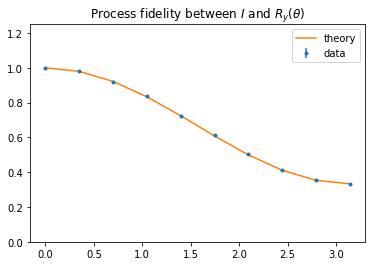

In [28]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="data")
pyplot.plot(np.linspace(0, np.pi, points), 
            (4*np.cos(np.linspace(0, np.pi, points)/2)**2+2)/6,
            label="theory")
#pyplot.axhline(0.2380952380952381+0.1, color="red", ls="--")
pyplot.legend()
pyplot.ylim(0,1.25)
pyplot.title(r"Process fidelity between $I$ and $R_y(\theta)$")

### Monte Carlo

In [29]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    ii_proc_mc.program = Program(RY(theta,0))
    ii_proc_mc_data = acquire_dfe_data(qvm, ii_proc_mc, num_shots=500)
    fid_est, fid_std_err = estimate_dfe(ii_proc_mc_data, 'process')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

In [ ]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="data")
pyplot.plot(np.linspace(0, np.pi, points), 
            (4*np.cos(np.linspace(0, np.pi, points)/2)**2+2)/6,
            label="theory")
pyplot.legend()
pyplot.ylim(0,1.25)
pyplot.title(r"Process fidelity between $I$ and $R_y(\theta)$")

## Advanced 

In [36]:
# 1. include qubits that have nothing done to them (leave then in zero to measure x talk)
# 2. prepare those qubits in |+>

In [ ]:
# Parallel state and process DFE